In [ ]:
%pip install bertopic 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import bertopic
from bertopic import BERTopic


/opt/anaconda3/envs/compss211/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_csv('../data/SPOTIFY_REVIEWS_tokens.csv')
df.shape

(3308617, 13)

In [5]:
import datetime as dt
df['review_timestamp'] = pd.to_datetime(df['review_timestamp'])
df2 = df[(df['review_timestamp'] >= '2019-11-15') & (df['review_timestamp'] <= '2023-11-15')]
print("Original:", len(df))
print("After the most recent 5 year:", len(df2))

Original: 3308617
After the most recent 5 year: 1669701


In [6]:
df_final = df2[~df2['length_type'].isin(['Short', 'Very short'])].reset_index(drop=True)
print(df2['length_type'].value_counts())
print(df_final['review_rating'].value_counts())


length_type
Very short    614051
Long          587948
Short         269962
Medium        197652
Name: count, dtype: int64
review_rating
5    310410
1    248160
4     92271
3     69013
2     65834
Name: count, dtype: int64


In [7]:
df_final = df_final[~df_final['review_text'].isin(['[deleted]', '[removed]'])].reset_index(drop=True)
df_final.shape
df_final.head()

,Unnamed: 0,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp,raw_word_count,length_type,length_type2,tokens
0,1663991,979989f1-78a2-4576-a783-c763ae7a9ffa,157768270865747512306,A Google user,I love the fact that I can listen to nearly an...,4,1,8.5.31.676,2019-11-15 00:02:50,68.0,Long,Long,"['i', 'love', 'the', 'fact', 'that', 'i', 'can..."
1,1663997,bd98f73f-1bb1-42f8-ad7a-d12f4c3662e9,280812221700598190021,A Google user,Randomly stops playing.... I will be listening...,2,2,8.5.31.676,2019-11-15 00:18:54,64.0,Long,Long,"['randomly', 'stops', 'playing', '.', '.', '.'..."
2,1663998,7167a53f-b1c0-4eae-9f33-26295c73de76,765391996510868237903,A Google user,So far this has been a better experience than ...,5,0,8.5.31.676,2019-11-15 00:19:11,22.0,Long,Long,"['so', 'far', 'this', 'has', 'been', 'a', 'bet..."
3,1664000,9fb431b7-7f2b-494c-8f0d-2805dec40b70,307958352133874143584,A Google user,Great app for looking up and listening to ur f...,5,0,NaN,2019-11-15 00:20:11,11.0,Long,Long,"['great', 'app', 'for', 'looking', 'up', 'and'..."
4,1664001,e3872654-d562-422e-96c1-d2480db446f4,180538848993703574960,A Google user,I love this app so .uch cause zi get to listen...,5,0,8.5.29.828,2019-11-15 00:20:20,18.0,Long,Long,"['i', 'love', 'this', 'app', 'so', '.', 'uc', ..."


In [8]:
import re

def light_clean(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_final['review_text_clean'] = df_final['review_text'].apply(light_clean)



In [9]:

df_good_all = df_final[(df_final["review_rating"] == 4) | (df_final["review_rating"] == 5)]


docs_good = df_good_all["review_text_clean"].astype(str).tolist()

df_bad_all = df_final[df_final["review_rating"] == 1 | (df_final["review_rating"] == 2)]

docs_bad = df_bad_all["review_text_clean"].astype(str).tolist()

print(len(docs_good), len(docs_bad))


402681 248160


In [10]:
#%pip install scikit-learn
#%pip install PCA
from sklearn.decomposition import PCA
from bertopic import BERTopic

#%pip install bertopic sentence-transformers umap-learn hdbscan scikit-learn



In [11]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import umap, hdbscan
import torch

device = "cpu"
emb_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)


def build_topic_model():
    # Vectorizer: relaxed min_df/max_df so c-TF-IDF doesn't error
    vectorizer = CountVectorizer(
        ngram_range=(1, 2),              # unigrams + bigrams
        min_df=1,                        # keep words appearing in >= 1 topic-doc
        # max_df left as default (=1.0) → no conflict with min_df
        stop_words="english",
        token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b"
    )

    # UMAP: dimensionality reduction
    umap_model = umap.UMAP(
        n_neighbors=10,
        n_components=3,
        min_dist=0.1,
        metric="cosine",
        n_epochs=50,
        random_state=42,
        verbose=True
    )

    # HDBSCAN: clustering
    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=200,            # larger → fewer, more stable topics
        metric="euclidean",
        cluster_selection_method="eom",
        prediction_data=False
    )

    topic_model = BERTopic(
        embedding_model=emb_model,
        vectorizer_model=vectorizer,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        language="english",
        low_memory=True,
        calculate_probabilities=False,
        nr_topics=50,        
        verbose=True
    )

    return topic_model






In [ ]:
print("\n=== Fitting BERTopic on GOOD (5-star) reviews ===")
topic_model_good = build_topic_model()
topics_good, probs_good = topic_model_good.fit_transform(docs_good)

topic_info_good = topic_model_good.get_topic_info()
print("\nGOOD topics (head):")
print(topic_info_good.head())

rep_good = topic_model_good.get_representative_docs()


2025-11-21 15:36:20,856 - BERTopic - Embedding - Transforming documents to embeddings.



=== Fitting BERTopic on GOOD (5-star) reviews ===


Batches:   0%|          | 0/12584 [00:00<?, ?it/s]

2025-11-21 19:39:40,346 - BERTopic - Embedding - Completed ✓
2025-11-21 19:39:40,369 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


UMAP(angular_rp_forest=True, metric='cosine', n_components=3, n_epochs=50, n_jobs=1, n_neighbors=10, random_state=42, verbose=True)
Fri Nov 21 19:39:42 2025 Construct fuzzy simplicial set
Fri Nov 21 19:39:46 2025 Finding Nearest Neighbors
Fri Nov 21 19:39:47 2025 Building RP forest with 37 trees
Fri Nov 21 19:58:16 2025 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	 5  /  19
	 6  /  19
	 7  /  19
	Stopping threshold met -- exiting after 7 iterations
Fri Nov 21 20:49:11 2025 Finished Nearest Neighbor Search
Fri Nov 21 20:49:18 2025 Construct embedding


Epochs completed:   0%|            0/50 [00:00]

	completed  0  /  50 epochs
	completed  5  /  50 epochs
	completed  10  /  50 epochs
	completed  15  /  50 epochs
	completed  20  /  50 epochs
	completed  25  /  50 epochs
	completed  30  /  50 epochs
	completed  35  /  50 epochs
	completed  40  /  50 epochs
	completed  45  /  50 epochs
Fri Nov 21 21:43:39 2025 Finished embedding


2025-11-21 21:43:47,133 - BERTopic - Dimensionality - Completed ✓
2025-11-21 21:43:47,153 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid usi


GOOD topics (head):
   Topic   Count                               Name  \
0     -1  138393            -1_app_music_songs_good   
1      0   73415  0_spotify_love spotify_love_music   
2      1   59178         1_app_music_music app_best   
3      2   21512           2_music_listen_love_easy   
4      3   18959               3_use_good_easy_love   

                                      Representation  \
0  [app, music, songs, good, great, love, song, l...   
1  [spotify, love spotify, love, music, premium, ...   
2  [app, music, music app, best, best music, song...   
3  [music, listen, love, easy, great, platform, s...   
4  [use, good, easy, love, easy use, far, great, ...   

                                 Representative_Docs  
0  [One of the best app to listen to songs, Good ...  
1  [Love to Spotify love to music 💋❤, Love spotif...  
2  [This is a great app for music, This music app...  
3  [Easy to use. All the music u want, I love mus...  
4  [so so so so good . . . . . . . ⭐

Exception ignored in: <function ResourceTracker.__del__ at 0x107381bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102f21bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103aedbc0>
Traceback (most recent call last

In [13]:
print("\n=== Fitting BERTopic on BAD (1-star) reviews ===")
topic_model_bad = build_topic_model()
topics_bad, probs_bad = topic_model_bad.fit_transform(docs_bad)

topic_info_bad = topic_model_bad.get_topic_info()
print("\nBAD topics (head):")
print(topic_info_bad.head())

rep_bad = topic_model_bad.get_representative_docs()


=== Fitting BERTopic on BAD (1-star) reviews ===


2025-11-22 14:47:09,500 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/7755 [00:00<?, ?it/s]

2025-11-22 15:12:20,861 - BERTopic - Embedding - Completed ✓
2025-11-22 15:12:20,865 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


UMAP(angular_rp_forest=True, metric='cosine', n_components=3, n_epochs=50, n_jobs=1, n_neighbors=10, random_state=42, verbose=True)
Sat Nov 22 15:12:21 2025 Construct fuzzy simplicial set
Sat Nov 22 15:12:21 2025 Finding Nearest Neighbors
Sat Nov 22 15:12:21 2025 Building RP forest with 30 trees
Sat Nov 22 15:12:51 2025 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
	 6  /  18
	Stopping threshold met -- exiting after 6 iterations
Sat Nov 22 15:13:31 2025 Finished Nearest Neighbor Search
Sat Nov 22 15:13:34 2025 Construct embedding


Epochs completed:   0%|            0/50 [00:00]

	completed  0  /  50 epochs
	completed  5  /  50 epochs
	completed  10  /  50 epochs
	completed  15  /  50 epochs
	completed  20  /  50 epochs
	completed  25  /  50 epochs
	completed  30  /  50 epochs
	completed  35  /  50 epochs
	completed  40  /  50 epochs
	completed  45  /  50 epochs
Sat Nov 22 15:15:31 2025 Finished embedding


2025-11-22 15:15:34,091 - BERTopic - Dimensionality - Completed ✓
2025-11-22 15:15:34,109 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid usi


BAD topics (head):
   Topic  Count                         Name  \
0     -1  87145      -1_app_songs_song_music   
1      0  44786  0_spotify_premium_music_app   
2      1  19929          1_ads_ad_song_songs   
3      2   9997   2_app_song_music_music app   
4      3   9212    3_app_worst_worst app_bad   

                                                                      Representation  \
0           [app, songs, song, music, play, premium, just, update, playlist, listen]   
1              [spotify, premium, music, app, songs, song, update, just, play, like]   
2                 [ads, ad, song, songs, minutes, music, app, listen, ads ads, free]   
3           [app, song, music, music app, worst, premium, songs, play, listen, want]   
4  [app, worst, worst app, bad, update, bad app, app worst, hate, hate app, app bad]   

                                                                                                                                                                  

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Full topic words
topic_info_good = topic_model_good.get_topic_info()
display(topic_info_good)

# Full representative documents
rep_good = topic_model_good.get_representative_docs()

for topic in rep_good:
    print(f"\n=== TOPIC {topic} ===")
    for doc in rep_good[topic]:
        print(doc)
        print("------")


,Topic,Count,Name,Representation,Representative_Docs
0,-1,138393,-1_app_music_songs_good,"[app, music, songs, good, great, love, song, like, listen, best]","[One of the best app to listen to songs, Good App to listen to music on the go., Amazing app The best app to listen to any music you want]"
1,0,73415,0_spotify_love spotify_love_music,"[spotify, love spotify, love, music, premium, app, like, listen, songs, ve]","[Love to Spotify love to music 💋❤, Love spotify!! My go too for music, How could you not have and love Spotify?]"
2,1,59178,1_app_music_music app_best,"[app, music, music app, best, best music, songs, love app, great, love, listen]","[This is a great app for music, This music app is very very best app I Love this app, The best music app ever. I love it]"
3,2,21512,2_music_listen_love_easy,"[music, listen, love, easy, great, platform, songs, easy use, selection, music love]","[Easy to use. All the music u want, I love music , i love spotify❤, I LOVE THE MUSIC LOVE WHOEVER MADE IT]"
4,3,18959,3_use_good_easy_love,"[use, good, easy, love, easy use, far, great, just, day, like]","[so so so so good . . . . . . . ⭐⭐⭐⭐⭐ . . . . . . ., I love how easy you are to use, I love it, its easy to use and well made :)]"
5,4,15945,4_app_love app_love_good app,"[app, love app, love, good app, good, great app, stars, amazing, best app, app love]","[Love this app you should get it, IT A VERY GOOD APP!!! I LOVE THIS APP, It is a very good app I love this app and I have it it is so good 😊]"
6,5,9902,5_ads_ad_app ads_good,"[ads, ad, app ads, good, annoying, premium, good ads, app, ads good, just]","[It's a good app but too much ads, It's a good app. But too much ads., The very good app is this but the ads]"
7,6,7735,6_ads_premium_free_commercials,"[ads, premium, free, commercials, music, songs, listen, ad, song, good]","[Best for music but there are so many ads in between 2 or 3 songs, Good for music Ads are Annoying though, I get to listen to all my music for free]"
8,7,6549,7_lyrics_lyrics songs_lyrics song_song,"[lyrics, lyrics songs, lyrics song, song, add lyrics, songs, app, feature, songs lyrics, song lyrics]","[This is the best music app! But please give lyrics of song, Great app, but at least put the lyrics to the full song., Could you add lyrics for each songs? ;(]"
9,8,4816,8_premium_worth_app premium_good,"[premium, worth, app premium, good, app, premium worth, free, good premium, premium good, pay]","[I love this app. Premium is a must, well worth it!, Good app, premium is 100% worth it, I will never take the premium 😂]"



=== TOPIC -1 ===
One of the best app to listen to songs
------
Good App to listen to music on the go.
------
Amazing app The best app to listen to any music you want
------

=== TOPIC 0 ===
Love to Spotify love to music 💋❤
------
Love spotify!! My go too for music
------
How could you not have and love Spotify?
------

=== TOPIC 1 ===
This is a great app for music
------
This music app is very very best app I Love this app
------
The best music app ever. I love it
------

=== TOPIC 2 ===
Easy to use. All the music u want
------
I love music , i love spotify❤
------
I LOVE THE MUSIC LOVE WHOEVER MADE IT
------

=== TOPIC 3 ===
so so so so good . . . . . . . ⭐⭐⭐⭐⭐ . . . . . . .
------
I love how easy you are to use
------
I love it, its easy to use and well made :)
------

=== TOPIC 4 ===
Love this app you should get it
------
IT A VERY GOOD APP!!! I LOVE THIS APP
------
It is a very good app I love this app and I have it it is so good 😊
------

=== TOPIC 5 ===
It's a good app but too m

In [ ]:
# Show full text in Jupyter (no truncation)
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Full topic words
topic_info_bad = topic_model_bad.get_topic_info()
display(topic_info_bad)

# Full representative documents
rep_bad = topic_model_bad.get_representative_docs()

for topic in rep_bad:
    print(f"\n=== TOPIC {topic} ===")
    for doc in rep_bad[topic]:
        print(doc)
        print("------")


,Topic,Count,Name,Representation,Representative_Docs
0,-1,8276,-1_app_premium_update_just,"[app, premium, update, just, new, don, like, worst, use, bad]","[Why cant i pay using the app even after i update the app?, In this app to many adds are there.. So don't like this app.., Very bad app too much adds I don't like this app]"
1,0,29454,0_app_song_spotify_songs,"[app, song, spotify, songs, music, play, premium, listen, just, ads]","[Literally the worst music playing app ever. When I search up a song I want to listen to and I press the play button it plays something completely different, and also you only get 6 skips and when you use all those up there is no way to listen to a different song your just stuck listening to 1 song until it's over, and you have to pay money to turn off shuffle play when it used to be free, do not download. I would give a 0 but I have to give at least 1., I really like I can search any song I want but I can't play the song I want it plays a suggested song and won't let play any song, why would you do this to me spotify?!?]"
2,1,5812,1_app_premium_ads_update,"[app, premium, ads, update, worst, bad, worst app, don, just, time]","[After this update the app has become worst, I have this app very bad app, This app is good but new update is worst part of this app]"
3,2,1570,2_hai_ke_bhi_ka,"[hai, ke, bhi, ka, ki, ho, nhi, hi, se, ko]","[Sirf premium dal kar aap ko barbaad kar diye ho, Har click par buy premium show kar Raha hai. Isse to achha hai ki apna app hi hata do playstore se kyunki besharmi ki to had hi para kar di hai tumlogon ne. Apna song tak khud se select nhi kar sakte, kya soch kar aise update kiye ho aur jo songs remove kar rahe to uska to kya hi kahna, kuch search karo to kuch aur hi dikhata hai. Lutne ka sirf zariya bana diye ho isko. Behtar hoga agar koi sudhar kar lo to., Itni bekar hai ye aap na koi playlist chala skte hai na song ka koi ek line sun skte hai . Premium leye bina kuch nahi dete, Bina premium kuch nahi bekar hai ye mat kro download 🥲 . Inke liye ek hi baat hai update esa kro ki 4 nahi sare users aap uninstall kr de, Aap starting me thik but abhi isse faltu app kahi nahi dekha hai. Abhi na toh aap gaana age piche kar sakte ho aur toh aur kabhi kabhi 1 se 2 gaane baad hi aa jate hai aur ab toh had hi kar di ab gaane bhi apne pasand ke nahi sun sakte Jo baj Raha hai wahi suna pad raha hai I mean had hai bhai premium ke liye itna dimag kar diya Agar 0 star de sakte toh mein wahi deta me is app ko]"
4,3,1275,3_login_log_account_password,"[login, log, account, password, email, sign, app, try, link, says]","[I had worst experience with this app. Account log out every 2 days and won't log in back with the same email ... and to access the app again you have to make another account I already made 2 accounts and now again its log out automatically and I am not able to log in with my email or my number.... its just say your email and phone number is invalid in sing in section and when I tried to create another account it says you already have an account... what should I do, The app logged me out of my account. When I try to log back in it continuously tells me my password and username/email are incorrect. I tried to login through google and it says I already have an account with this email (yes, obviously). So I tried to login with the ""without password"" option...and then it says that my email/username is not associated with any account ?!????, Not able to login with my account..]"
5,4,837,4_sweden_quran_hate_islam,"[sweden, quran, hate, islam, love, love islam, hate app, boycott, app sweden, holy]","[I hate this app Sweden I love Islam ❤❤❤❤, I hate this App Sweden. I love Islam, I hate this app Sweden, I love Islam😌]"
6,5,713,5_rogan_joe_joe rogan_misinformation,"[rogan, joe, joe rogan, misinformation, support, spotify, speech, young, neil, platform]","[Only here for Joe Rogan. Everything else sucks!, How do you like Joe Rogan now?, They still have joe Rogan podcast so this is a no 


=== TOPIC -1 ===
Why cant i pay using the app even after i update the app?
------
In this app to many adds are there.. So don't like this app..
------
Very bad app too much adds I don't like this app
------

=== TOPIC 0 ===
Literally the worst music playing app ever. When I search up a song I want to listen to and I press the play button it plays something completely different, and also you only get 6 skips and when you use all those up there is no way to listen to a different song your just stuck listening to 1 song until it's over, and you have to pay money to turn off shuffle play when it used to be free, do not download. I would give a 0 but I have to give at least 1.
------
I really like I can search any song I want but I can't play the song I want it plays a suggested song and won't let play any song
------
why would you do this to me spotify?!?
------

=== TOPIC 1 ===
After this update the app has become worst
------
I have this app very bad app
------
This app is good but new 

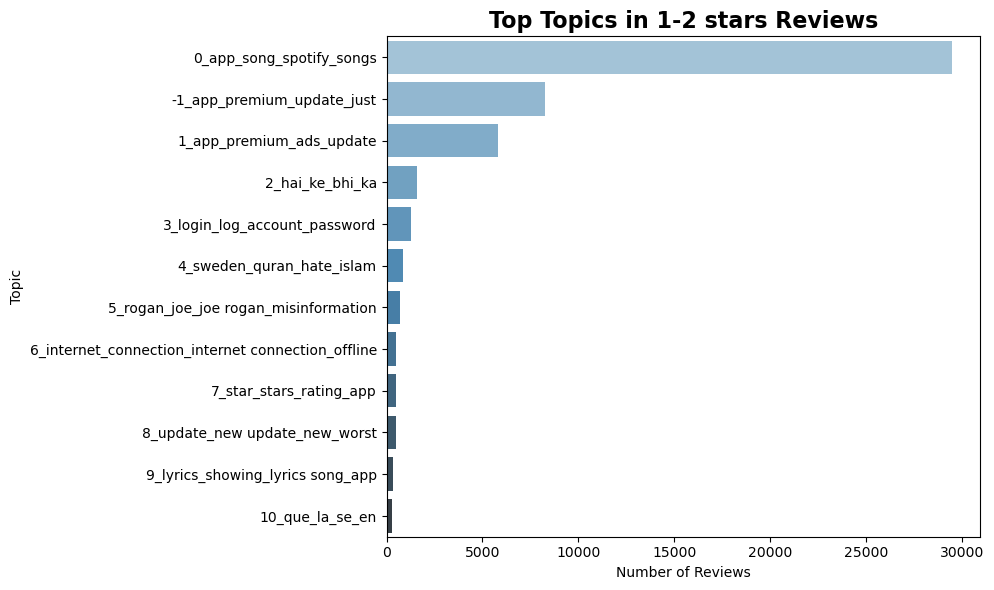

In [4]:

topic_info = topic_model_bad.get_topic_info().sort_values("Count", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=topic_info.head(15),
    y="Name",
    x="Count",
    palette="Blues_d"
)

plt.title("Top Topics in 1-2 stars Reviews", fontsize=16, weight="bold")
plt.xlabel("Number of Reviews")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()


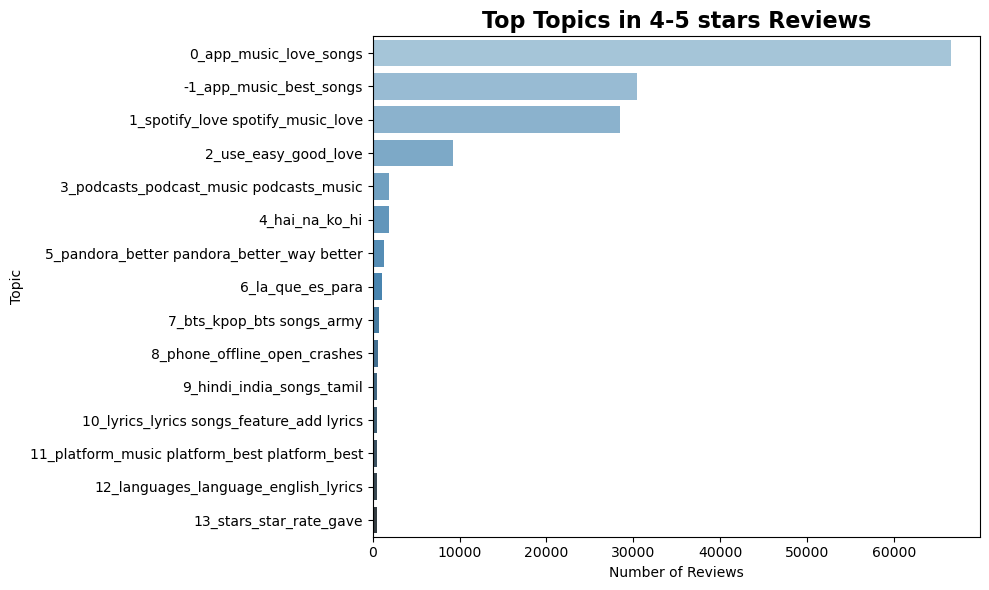

In [4]:

topic_info = topic_model_good.get_topic_info().sort_values("Count", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=topic_info.head(15),
    y="Name",
    x="Count",
    palette="Blues_d"
)

plt.title("Top Topics in 4-5 stars Reviews", fontsize=16, weight="bold")
plt.xlabel("Number of Reviews")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()
